In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/colab-data/kaggle.json' 'kaggle.json'
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json



Mounted at /content/drive


In [4]:
!kaggle competitions download -c digit-recognizer
!unzip train.csv.zip
!unzip test.csv.zip


 11% 1.00M/9.16M [00:00<00:01, 7.20MB/s]
100% 9.16M/9.16M [00:00<00:00, 36.3MB/s]
 16% 1.00M/6.09M [00:00<00:00, 6.43MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.2MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 70.4MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
# getting data from csv
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
#spliting into test dev

train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)
train_y = train.pop('label').values
train_X = train.copy().values.reshape(33600,28,28)
test_y = test.pop('label').values
test_X = test.copy().values.reshape(8400,28,28)

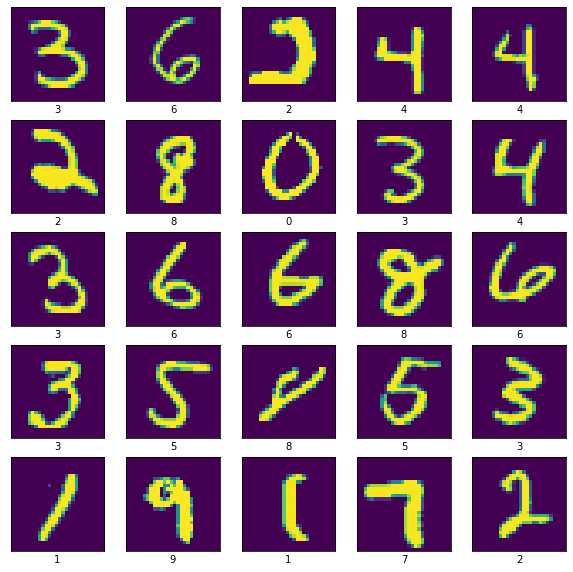

In [7]:
#Visualizing dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i])
    plt.xlabel(train_y[i])
plt.show()


In [10]:
# Model : CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE (FC)
def convolutional_model(input_shape,cats):
    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME' with relu
    Z1 = layers.Conv2D(filters=32,kernel_size=4,strides=1,padding='same' ,activation='relu')(input_img)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = layers.MaxPool2D(pool_size=(2,2), strides=4, padding='same')(Z1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = layers.Conv2D(filters=64,kernel_size=2,strides=1,padding='same',activation='relu')(P1)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = layers.MaxPool2D(pool_size=(2,2), strides=4, padding='same')(Z2)
    ## FLATTEN
    F = layers.Flatten()(P2)
    ## Dense layer
    DL1 = layers.Dense(units=128,activation="relu")(F)
    ## 10 neurons in output layer.
    AL1 =  layers.Dropout(0.2)(DL1)
    outputs = layers.Dense(units=cats,activation="softmax")(AL1)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [11]:
# configuring model and using adam 
train_dataset = tf.data.Dataset.from_tensor_slices((train_X,to_categorical(train_y))).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((test_X,to_categorical(test_y))).batch(64)
conv_model = convolutional_model((28, 28, 1),10)
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896 

In [12]:
#training 
history = conv_model.fit(train_dataset,epochs=20,validation_data=test_dataset)

Epoch 1/20
525/525 [==============================] - 17s 30ms/step - loss: 1.0007 - accuracy: 0.7838 - val_loss: 0.2472 - val_accuracy: 0.9207
Epoch 2/20
525/525 [==============================] - 15s 29ms/step - loss: 0.2693 - accuracy: 0.9158 - val_loss: 0.1857 - val_accuracy: 0.9406
Epoch 3/20
525/525 [==============================] - 16s 30ms/step - loss: 0.2054 - accuracy: 0.9349 - val_loss: 0.1721 - val_accuracy: 0.9465
Epoch 4/20
525/525 [==============================] - 16s 30ms/step - loss: 0.1720 - accuracy: 0.9443 - val_loss: 0.1466 - val_accuracy: 0.9538
Epoch 5/20
525/525 [==============================] - 16s 30ms/step - loss: 0.1477 - accuracy: 0.9513 - val_loss: 0.1569 - val_accuracy: 0.9495
Epoch 6/20
525/525 [==============================] - 15s 29ms/step - loss: 0.1352 - accuracy: 0.9534 - val_loss: 0.1481 - val_accuracy: 0.9545
Epoch 7/20
525/525 [==============================] - 15s 29ms/step - loss: 0.1273 - accuracy: 0.9574 - val_loss: 0.1429 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

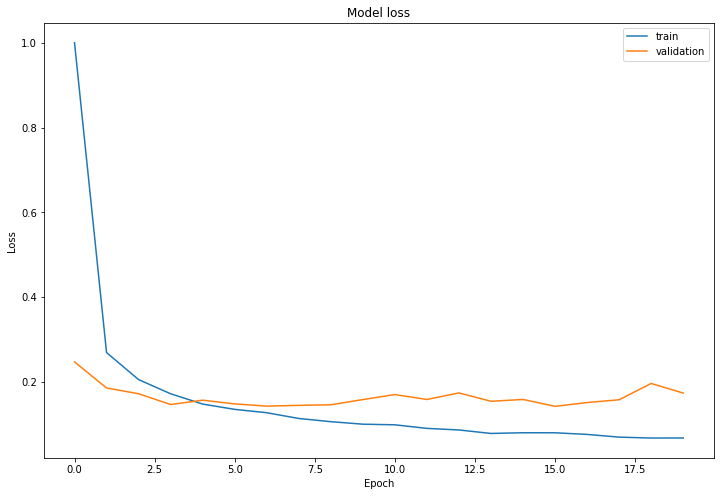

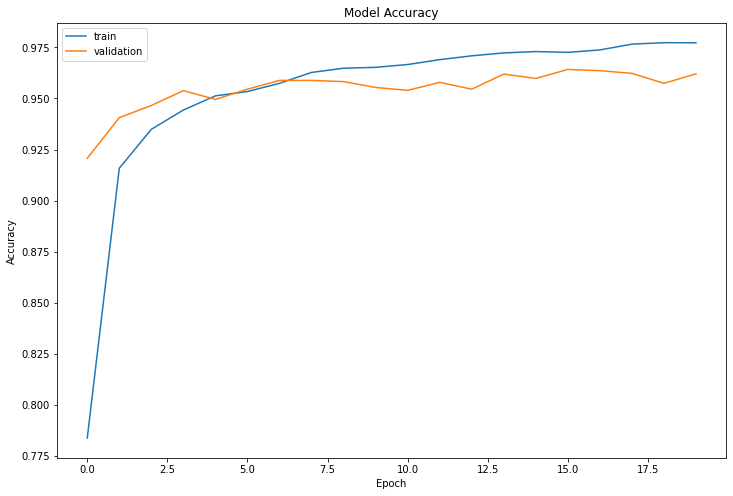

In [13]:
# visualizing losses
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [14]:
# predicting test values
df1 = pd.read_csv('test.csv')
df1.head()
X_test = df1.values.reshape(28000,28,28)
pred = conv_model.predict(X_test)


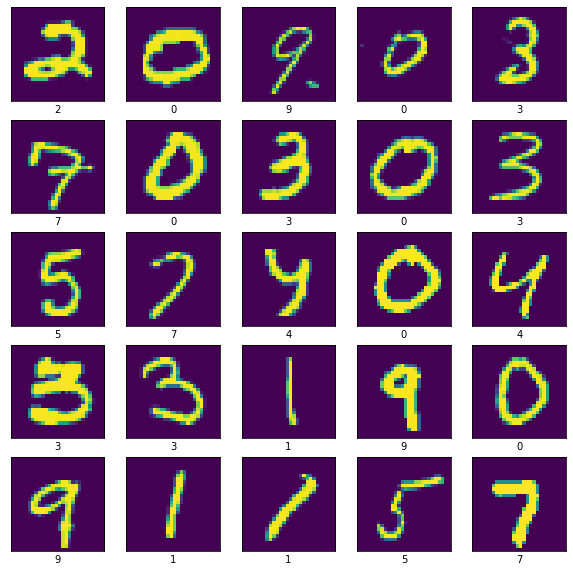

In [15]:
pred_Y = np.array(list(map(lambda a:list(a).index(max(a)),pred)))
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(pred_Y[i])
plt.show()

In [16]:
# submitting 
df2 = pd.DataFrame(data=zip(range(1,pred_Y.size+1),pred_Y),columns=['ImageId','Label'])

In [17]:
df2.to_csv('/content/drive/MyDrive/colab-data/submission.csv',index=False)

In [ ]:
df2

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,2
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
